In [1]:
import numpy as np
Nf = 1000
fmin = 0.5 # 1/micron => 150 THz
fmax = 0.8 # 1/micron => 300 THz
fre = np.linspace(fmin, fmax, Nf)
d1 = 0.2 # thickness in micron
d2 = 0.8 # thickness in micron
d = d1 + d2
epsi1 = 2
epsi2 = 13
omega = 2 * np.pi * fre

In [2]:
import meep as mp

resolution = 100                # pixels/um
dpml = 1.0                      # PML thickness
sz = 16 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

fcen = (fmin+fmax)/2          # center frequency
df = (fmax-fmin)                  # frequency width
dimensions = 1

In [3]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, 
                     center=mp.Vector3(z=-8))]

In [4]:
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        #Courant = 0.1,
                        resolution=resolution)
sim_vac.reset_meep()

refl_fr = mp.FluxRegion(center=mp.Vector3(z=-8))
refl = sim_vac.add_flux(fcen, df, Nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z= 8 ))
tran = sim_vac.add_flux(fcen, df, Nf, tran_fr)
   
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex,
                                                        mp.Vector3(z=0), 1e-3))

empty_flux = mp.get_fluxes(tran)
empty_data = sim_vac.get_flux_data(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000129938 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
time for set_epsilon = 0.00180697 s
-----------
field decay(t = 50.005): 0.25009647263049145 / 0.25009647263049145 = 1.0
field decay(t = 100.01): 1.5465591646764388e-12 / 0.25009647263049145 = 6.183850369458926e-12
run 0 finished at t = 100.01 (20002 timesteps)


In [5]:
# add a block with n=3.5 for the air-dielectric interface
geometry = []
Np = 4 ## number of repeating

for i in range (Np):
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d1), center=mp.Vector3(z = -6 + d * i),
                     material= mp.Medium(epsilon=epsi1)))
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d2), center=mp.Vector3(z = -6 + d * i + d /2),
                     material= mp.Medium(epsilon=epsi2))) 
for i in range (Np):
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d2), center=mp.Vector3(z = -6 + Np * d  + d * i),
                     material= mp.Medium(epsilon=epsi2)))
    geometry.append(mp.Block(mp.Vector3(mp.inf,mp.inf,d1), center=mp.Vector3(z = -6 + Np * d + d * i + d /2),
                     material= mp.Medium(epsilon=epsi1)))
    
sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)
tran = sim.add_flux(fcen, df, Nf, tran_fr)
refl = sim.add_flux(fcen, df, Nf, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-4))
#sim.run(until=10000)
refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)
freqs = mp.get_flux_freqs(refl)

R = np.empty(Nf)
T = np.empty(Nf)
for i in range(Nf):
        R[i] = -refl_flux[i]/empty_flux[i]
        T[i] = tran_flux[i]/empty_flux[i]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000152111 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 18 with resolution 100
     block, center = (0,0,-6)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-5.5)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-5)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-4.5)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-4)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (

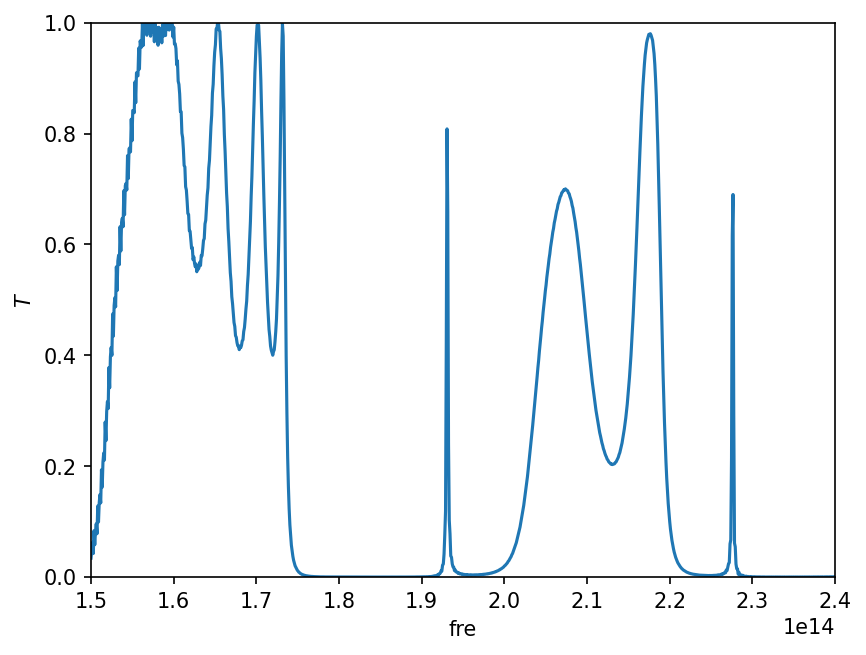

In [7]:
## compare numerical and analytical
from matplotlib import pyplot as plt 
plt.figure(dpi=150)
plt.plot(fre*3e14,T,'-',label='$T_{nur}$')
plt.xlabel("fre")
plt.ylabel("$T$")
#plt.legend(loc="upper right")
plt.xlim(1.5e14,2.4e14)
plt.ylim([0,1])
plt.savefig('1.5_2.4.png')
plt.show()